In [1]:
import json
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from ast import literal_eval
from multiprocessing import Pool
import re

from p4utils.utils.helper import load_topo

os.chdir('/home/user/dds/netscope/')


from analysis.reservoir import Reservoir
from analysis.algrithm import spectrum, diff
from analysis.utils import export_FSP, detect_abnormal_timespan, PPS
# from analysis.utils import Topo as T
# from analysis.topo import *
# from analysis.register import Register
from analysis.spmf import Spmf
from analysis.load import Loader

from sklearn.mixture import GaussianMixture


markers = (list('ov^<>12348sp*hH+xXDd|_.,')+[i for i in range(12)]) * 10

In [45]:
log_dir = './log/hosts'
log_dir = None
log_dir = '/mnt/netscope/data/lamp/test/20230222_0918GMT'
log_dir = '/mnt/netscope/data/lamp/ad_none/20230222_1131GMT'
log_dir = '/mnt/netscope/data/lamp/data/exp2/ad_long/20230302_0603GMT'
log_dir = '/mnt/netscope/data/lamp/data/exp2/ad_long/20230302_0554GMT'
log_dir = '/mnt/netscope/data/lamp/ad_long/20230302_0738GMT'

loader = Loader(log_dir)

topo = loader.get_topo()

hosts = loader.load_hosts(debug=True)
# digests = loader.load_digest()
# latencys = loader.load_latency()

hosts['path_str'] = hosts.debug.apply(lambda x: "".join([f"s{d['sw_id']}," for d in x]))
hosts['whole_path'] = hosts.apply(lambda row: row.src + ',' + row.path_str + row.dst, axis=1)
hosts['5tuple'] = hosts.apply(lambda row: f"{row.src}-{row.dst}-{row.src_port}-{row.dst_port}-{row.protocol}", axis=1)


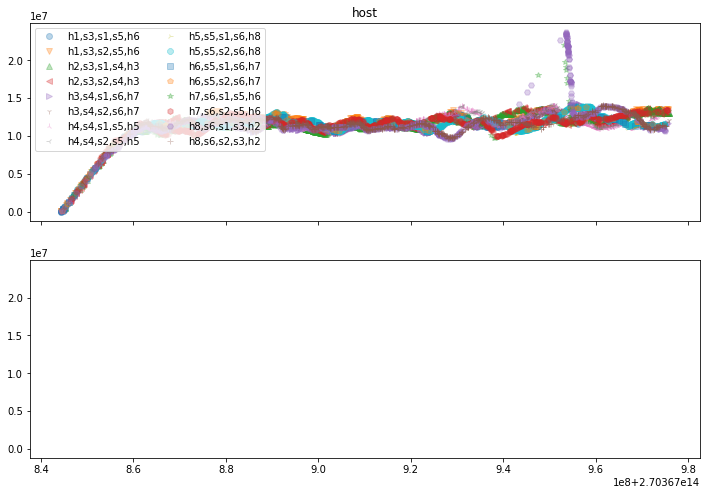

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(12, 8))
x_key = 'arrive_t'
for i, path in enumerate(sorted(hosts.whole_path.unique())):
    hosts[hosts.whole_path == path].plot(x_key, 'latency', ax=axes[0], label=path, alpha=0.3, lw=1, marker=markers[i], ls='')
    axes[0].set_title('host')
    axes[0].legend(ncol=2)

# ground truth

In [47]:
flow_dfs = {}
start_timestamp = hosts.receive_t.min()
for tuple in sorted(hosts['5tuple'].unique()):
    # cut off 2e7 ms in the begining, as the network is just initializing
    tdf = hosts[(hosts['5tuple']==tuple) & (hosts.receive_t > start_timestamp + 2e7)]
    if len(tdf) < 50: 
        continue
    flow_dfs[tuple] = tdf.copy(deep=True).reset_index(drop=True)


In [48]:
def process_reservoir(flow_df):
    '''reservoir for each flow'''
    zoom = 1e3
    c_th = 5 # counter threshold
    flow_reservoir = Reservoir(volumn=100, sigma_num=3)
    for i, row in flow_df.iterrows():
        flow_df.loc[i, 'lier'] = flow_reservoir.feed(row['latency']/zoom)
        
        if len(flow_reservoir.R_sub) > 0:
            reservoir_m = np.median(flow_reservoir.R_sub) * zoom 
            reservoir_std3 = np.std(flow_reservoir.R_sub) * flow_reservoir.sigma_num * zoom 
            reservoir_out = reservoir_std3 + reservoir_m
        else:
            reservoir_out = 0
            reservoir_m = 0
            reservoir_std3 = 0
        flow_df.loc[i, 'threshold'] = reservoir_out

    return flow_df

with Pool(len(flow_dfs.keys())) as p:
    map_dfs = p.map(process_reservoir, flow_dfs.values())
map_df = pd.concat(map_dfs)

Text(0, 0.5, 'latency (us)')

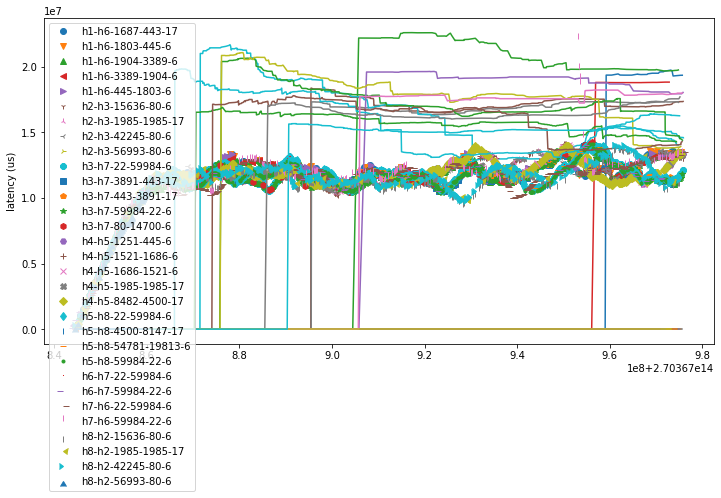

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12, 6)) 
for i, (tuple, tdf) in enumerate(map_df.groupby("5tuple")):
    # if tuple != "h3-h1-1251-445-6": continue
    tdf = tdf.sort_values('arrive_t')
    # print(tuple, len(tdf))
    line = plt.plot(tdf['arrive_t'], tdf['latency'], marker=markers[i], ls='', label=tuple)
    plt.plot(tdf['arrive_t'], tdf['threshold'], c=line[0].get_color())
plt.legend()
plt.ylabel("latency (us)")
# plt.show()
# plt.ylim(0, 1663629303)

# Controller

In [50]:
LC = pd.read_csv(os.path.join(log_dir, "mininet/hosts/LC.csv"))

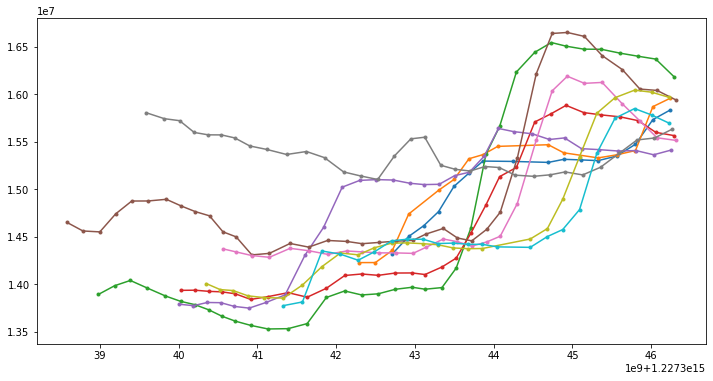

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12, 6)) 

for flow, fdf in LC.groupby("flow"):
    plt.plot(fdf['timestamp'], fdf['threshold'], label=flow, marker='.')
# plt.legend()

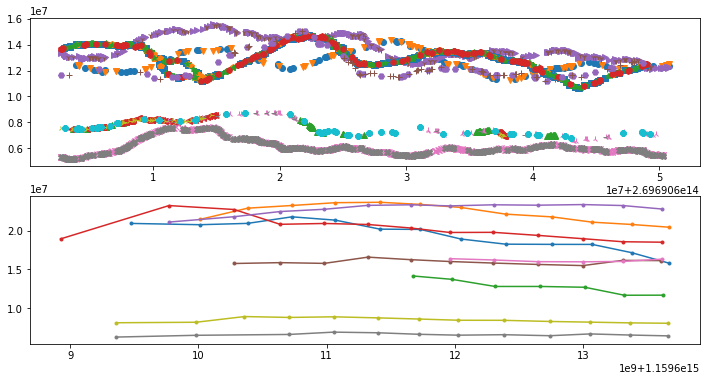

In [105]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=False, figsize=(12, 6)) 

for i, (tuple, tdf) in enumerate(map_df.groupby("5tuple")):
    # if tuple != "h3-h1-1251-445-6": continue
    tdf = tdf.sort_values('arrive_t')
    # print(tuple, len(tdf))
    line = axes[0].plot(tdf['arrive_t'], tdf['latency'], marker=markers[i], ls='', label=tuple)


for flow, fdf in LC.groupby("flow"):
    axes[1].plot(fdf['timestamp'], fdf['threshold'], label=flow, marker='.')